# Euclid école d'été Rodolphe Clédassou

## TD weak lensing cycle 2

### Solutions

2023

Martin Kilbinger martin.kilbinger@cea.fr

In [2]:
# Load some libraries
import sys
import os

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline

# 1. Set-up

In [3]:
# Load catalogue with all objects (detected on stacks/tiles)

# On machines with small RAM open with memory mapped on disk
mmap_mode = "r"

# With large RAM no memory mapping is necessary
# mmap_mode = None

dd = np.load("final_cat_small.npy", mmap_mode=mmap_mode)

In [4]:
# Print the column names
print(dd.dtype.names)

('XWIN_WORLD', 'YWIN_WORLD', 'TILE_ID', 'FLAGS', 'IMAFLAGS_ISO', 'NGMIX_MCAL_FLAGS', 'NGMIX_ELL_PSFo_NOSHEAR', 'SPREAD_CLASS', 'SPREAD_MODEL', 'SPREADERR_MODEL', 'N_EPOCH', 'NGMIX_N_EPOCH', 'NGMIX_ELL_1M', 'NGMIX_ELL_1P', 'NGMIX_ELL_2M', 'NGMIX_ELL_2P', 'NGMIX_ELL_NOSHEAR', 'NGMIX_ELL_ERR_NOSHEAR', 'NGMIX_FLAGS_1M', 'NGMIX_FLAGS_1P', 'NGMIX_FLAGS_2M', 'NGMIX_FLAGS_2P', 'NGMIX_FLAGS_NOSHEAR', 'NGMIX_T_1M', 'NGMIX_T_1P', 'NGMIX_T_2M', 'NGMIX_T_2P', 'NGMIX_T_NOSHEAR', 'NGMIX_T_ERR_1M', 'NGMIX_T_ERR_1P', 'NGMIX_T_ERR_2M', 'NGMIX_T_ERR_2P', 'NGMIX_T_ERR_NOSHEAR', 'NGMIX_Tpsf_1M', 'NGMIX_Tpsf_1P', 'NGMIX_Tpsf_2M', 'NGMIX_Tpsf_2P', 'NGMIX_Tpsf_NOSHEAR', 'NGMIX_FLUX_1M', 'NGMIX_FLUX_1P', 'NGMIX_FLUX_2M', 'NGMIX_FLUX_2P', 'NGMIX_FLUX_NOSHEAR', 'NGMIX_FLUX_ERR_1M', 'NGMIX_FLUX_ERR_1P', 'NGMIX_FLUX_ERR_2M', 'NGMIX_FLUX_ERR_2P', 'NGMIX_FLUX_ERR_NOSHEAR', 'FLAG_TILING', 'MAG_AUTO', 'SNR_WIN', 'NGMIX_T_PSFo_NOSHEAR', 'NGMIX_MOM_FAIL')


In [5]:
# Excercise 1.1: Print the number of objects

print(len(dd))
print(dd.shape[0])
print(f"{len(dd)/1e6:.2f} million")

1126718
1126718
1.13 million


## 2. Spatial distribution and selecting galaxies

In [6]:
plt.rcParams.update({"figure.figsize": [10, 10], "font.size": 20})

In [7]:
# Exercise 2.1: Look at the distribution of the objects on the sky.

# Plot 2D distribution of all objects use XWIN_WORLD YWIN_WORLD

# You should see some weird patterns and clustered areas

def plot_spatial(dd, out_path):
    plt.hexbin(dd["XWIN_WORLD"], dd["YWIN_WORLD"], gridsize=1000)
    plt.xlabel("R.A. [deg]")
    plt.ylabel("Dec [deg]")
    plt.savefig(out_path)

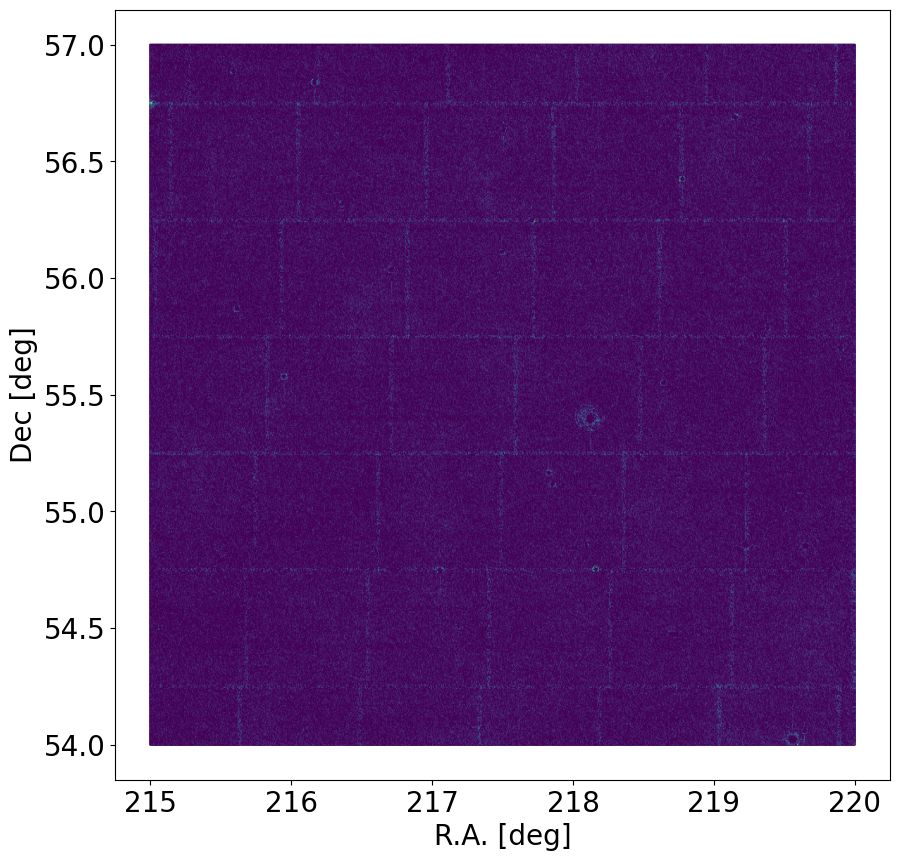

In [8]:
plot_spatial(dd, "ra_dec_distribution.png")

### Apply cuts and select galaxies.

In [8]:
# We need to clean up the sample and remove unwanted objects. The information about those objects
# is in the catalogue. For this we define a mask.

# The following values are those to *keep*.

# remove duplicates on overlapping tiles
# 'FLAG_TILING' = 1 (objects with 'FLAG_TILING' = 0 are duplicates)

# masked objects
# 'FLAG' = 0 (object outside mask, e.g. close to Messier or NGC object, bad CCD region, cosmic ray)
# 'IMAFLAGS_ISO' = 0 (SExtractor unflagged object)

# Exercise 2.2:
# a) Apply the above critera to the input catalogue.

mask = (
    (dd['FLAG_TILING'] == 1)
    & (dd['FLAGS'] == 0)
    & (dd['IMAFLAGS_ISO'] == 0)
)

ddm = dd[mask]

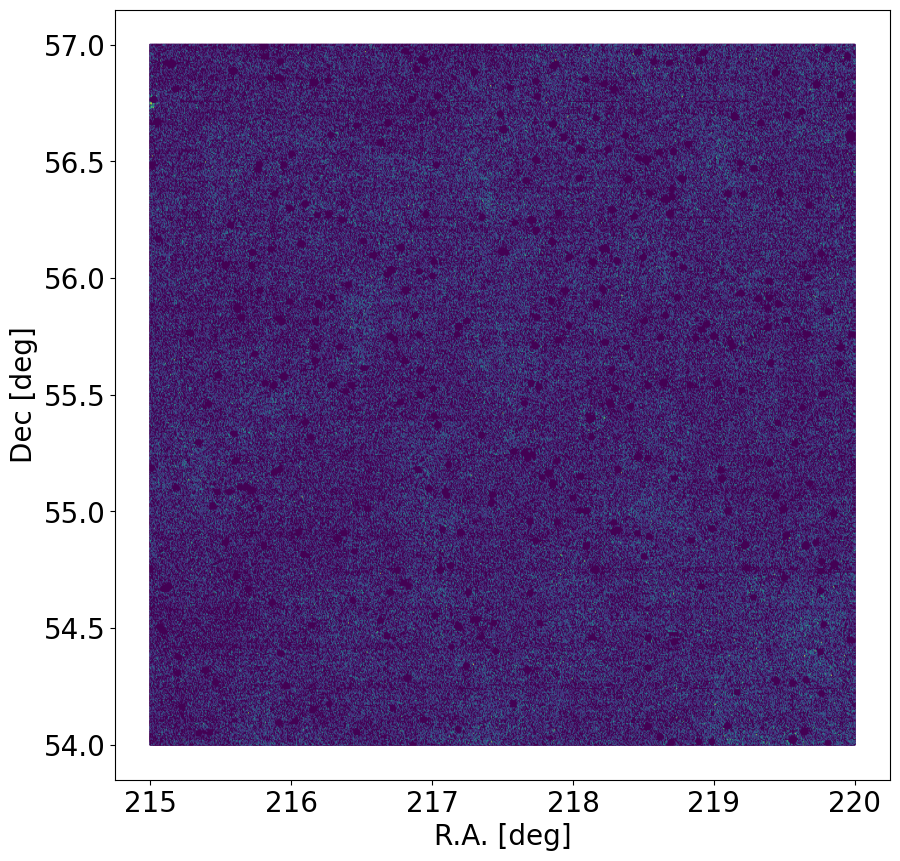

In [9]:
# c) Replot spatial distribution with cleaned sample
plot_spatial(ddm, "ra_dec_distribution_sel1.png")

In [10]:
# Some more flags should be applied, for which PSF or shape measurement did not work.

# As before, the following values are those to *keep*.

# 'NGMIX_MCAL_FLAGS' = 0 (shape measurement ngmix did not fail)
# 'NGMIX_ELL_PSFo_NOSHEAR' != -10 (this entry has two components; valid PSF)
# 'NGMIX_MOM_FAIL' = 0 (2nd-order moment measurements with ngmix did not fail)

# 'NGMIX_N_EPOCH' > 1 (use objects with more than one exposure.)
# For this last criterium you can also try > 0 (less conservative) or > 2 (more conservative)

# Exercise 2.3:
# a) Apply the above additional critera to the input catalogue.
# b) Print number and fraction of selected objects.
# c) Replot spatial distribution with cleaned sample

mask2 = (
    (ddm['NGMIX_MCAL_FLAGS'] == 0)
    & (ddm['NGMIX_ELL_PSFo_NOSHEAR'][:,0] != -10)
    & (ddm['NGMIX_MOM_FAIL'] == 0)
    & (ddm['NGMIX_N_EPOCH'] > 0)
)

ddm2 = ddm[mask2]

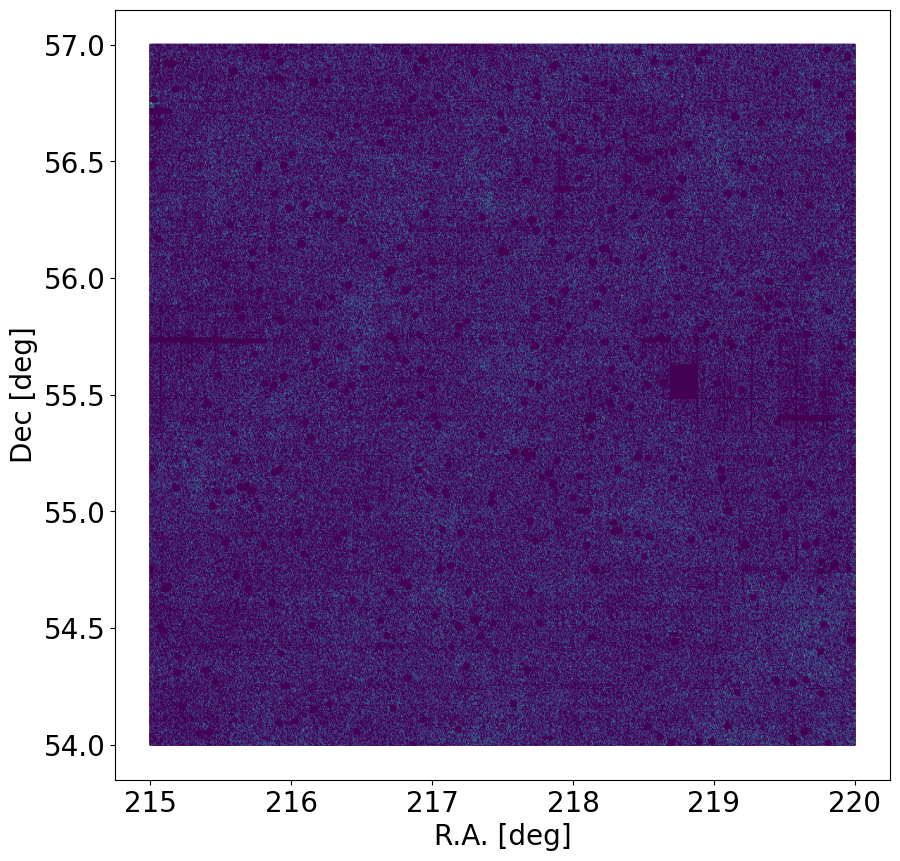

In [11]:
# c) Replot spatial distribution with cleaned sample
plot_spatial(ddm2, "ra_dec_distribution_sel1.png")

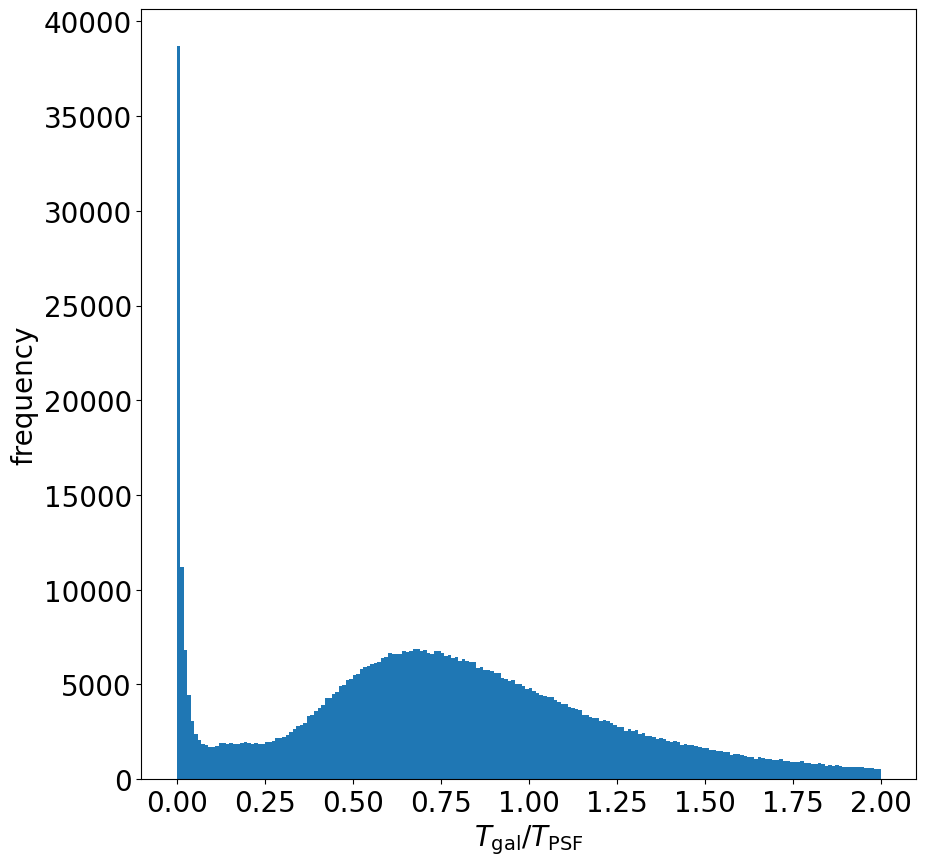

In [12]:
# Select galaxies. We could use SPREADMODEL from SExtractor, but a simpler criterium is just cut of the
# (original, PSF-deconvolved) object size compared to the PSF size at this position.

# 'NGMIX_T_NOSHEAR' / 'NGMIX_Tpsf_NOSHEAR' > 0.5 (ratio of galaxy to PSF size > 0.5)

# Excercise 2.4: Plot a histogram of the size ratio. What can you see?

# matplotlib version >= 3.7.2
#counts, bins = np.histogram(ddm2['NGMIX_T_NOSHEAR'] / ddm2['NGMIX_Tpsf_NOSHEAR'], bins=200, range=(0, 2))
#plt.hist(counts, bins)

plt.hist(ddm2['NGMIX_T_NOSHEAR'] / ddm2['NGMIX_Tpsf_NOSHEAR'], bins=200, range=(0, 2))

plt.xlabel(r"$T_{\rm gal} / T_{\rm PSF}$")
plt.ylabel("frequency")
_ = plt.savefig("size_hist.png")

# Excercise 2.5 (optional): Try out other values, e.g. 0.3 (less conservative) or 0.8 (more conservative).

In [13]:
# Excercise 2.6:
# a) Apply the above additional critera to the input catalogue.
# b) Print number and fraction of selected objects.

mask3 = ddm2['NGMIX_T_NOSHEAR'] / ddm2['NGMIX_Tpsf_NOSHEAR'] > 0.5

ddm3 = ddm2[mask3]

In [14]:
# b) Print number of selected objects.
print(f"Selected galaxies: {len(ddm3)} = {len(ddm3) / len(dd):.1%} of original catalogue")

Selected galaxies: 545617 = 48.4% of original catalogue


## 3. Shear calibration

For the shear calibration we use metacalibration.

### Compute calibration quantities

#### Multiplicative bias: shear response matrix

Remember the relation between observed galaxy ellipticity $\epsilon^{\rm obs}$ and shear $\gamma^{\rm true}$.

$$ \left\langle \epsilon^{\rm obs}\right\rangle = \left\langle R \right\rangle \gamma^{\rm true} + \left\langle c \right\rangle.$$

The shear response $R$ is the linear multiplicative shear bias. It 
can be interpreted as derivative of the observed ellipticit with respect to the shear, for a given galaxy:

$$R_{ij} = \frac{\partial \epsilon^{\rm obs}_i}{\partial \gamma^{\rm true}_j}.$$

In practise these derivatives are computed with finite differences, using galaxy images sheared articially by a small amount.

$$R_{ij} \approx \frac{\epsilon^{\rm obs}_i(+\Delta \gamma_j) - \epsilon^{\rm obs}_i(-\Delta \gamma_j)}{ 2 \Delta \gamma_j}.$$


The measured galaxy ellipticities of the sheared images are in the catalogue. The small shear is $\Delta \gamma = 0.01$.

In [15]:
# The columns of the measured ellipticity for metacalibration are as follows:

# 'NGMIX_ELL_1P': sheared by + Delta gamma_1
# 'NGMIX_ELL_1M': sheared by - Delta gamma_1
# 'NGMIX_ELL_2P': sheared by + Delta gamma_2
# 'NGMIX_ELL_2M': sheared by - Delta gamma_2

# These columns are arrays with two components, i.e.
# dd['NGMIX_ELL_1P'][:, 0] : epsilon_1
# dd['NGMIX_ELL_1P'][:, 1] : epsilon_2

# Excercise 3.1: Compute all four matrix elements for all galaxies.

dg = 0.01

R = {}
R["11"] = (ddm3['NGMIX_ELL_1P'][:,0] - ddm3['NGMIX_ELL_1M'][:,0]) / (2 * dg)
R["22"] = (ddm3['NGMIX_ELL_2P'][:,1] - ddm3['NGMIX_ELL_2M'][:,1]) / (2 * dg)
R["12"] = (ddm3['NGMIX_ELL_1P'][:,1] - ddm3['NGMIX_ELL_1M'][:,1]) / (2 * dg)
R["21"] = (ddm3['NGMIX_ELL_2P'][:,0] - ddm3['NGMIX_ELL_2M'][:,0]) / (2 * dg)

In [16]:
# Excercise 3.2:
# a) Compute the mean of each element (average over all galaxies).
# b) Create a 2x2 matrix of those mean values.

# You should get diagonal elements of around 0.55, and off-diagonal elements close to zero. 

m = np.mean
RR = np.array([[m(R["11"]), m(R["12"])], [m(R["21"]), m(R["22"])]])
print(RR)

[[ 5.54570435e-01 -1.23637640e-05]
 [-2.51444123e-03  5.45172248e-01]]


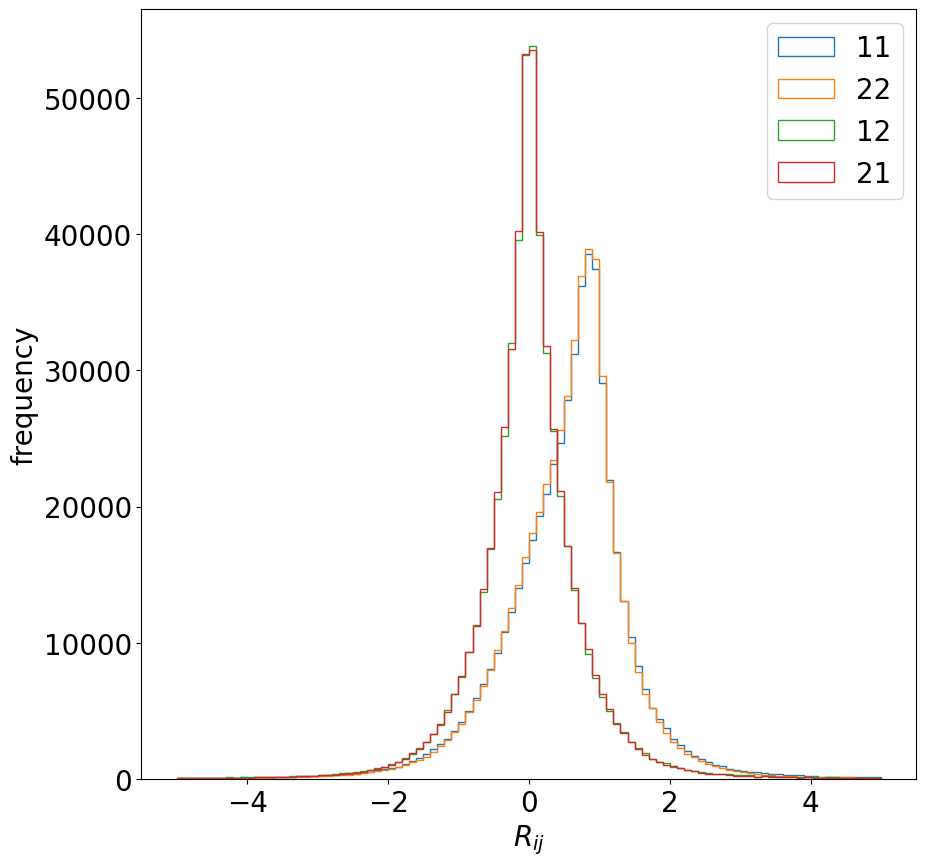

In [17]:
# Excercise 3.3 (optional): Plot distribution of the shear response matrix elements.

for ij in R:
    plt.hist(R[ij], bins=100, range=(-5, 5), histtype="step", label=ij)
plt.xlabel(r"$R_{ij}$")
plt.ylabel("frequency")
plt.legend()
_ = plt.savefig("Rij_hist.png")

#### Additive shear bias

The additive term is computed indepependent of the metacal shear response.

The additive shear bias is estimated as the mean galaxy ellipticity, assuming that the mean shear is zero. This
is over a fairly good assumption since we average over a large area. Thus,

$$c = \left\langle \epsilon^{\rm obs}\right\rangle.$$

In [18]:
# Excercise 3.4: Compute the two components of c

c = m(ddm3['NGMIX_ELL_NOSHEAR'], axis=0)
print(c)

[-0.00086829  0.00012469]


### Calibrate

We can apply the estimated multiplicative and additive biases to *calibrate the observed galaxy ellipticities,
and to obtain de-biased shear estimates.

For that we invert the above equation to solve for $\gamma^{\rm true}$. For each galaxy we compute its calibrated shear (estimate) as


$$\gamma^{\rm true} = \left\langle R \right\rangle^{-1} \left(
    \epsilon^{\rm obs} - \left\langle c \right\rangle
    \right).$$

In [19]:
# Excercise 3.5: Compute the calibrated shear for the W3 galaxy sample.

# Inverse shear response matrix
Rm1 = np.linalg.inv(RR)

eobs_minus_c = ddm3['NGMIX_ELL_NOSHEAR'] - c

# Compute calibrated shear
g_cal = Rm1.dot(eobs_minus_c.transpose())

print(g_cal.shape)

(2, 545617)


## 4. Cluster lensing

Compute the tangential shear distortion profile around Planck clusters.

In [20]:
# First, we extract a suitable cluster catalogue.

cluster_cat_name = 'HFI_PCCS_SZ-union_R2.08.fits.gz'
cl = fits.getdata(cluster_cat_name)

In [21]:
# Exercise 4.1: Select viable clusters in W3. Use the flags
# - "MSZ" != 0 (SZ mass measured)
# - "COSMO" != 0 (good for cosmology)

# and select clusters in W3 footprint. Be conservative with the cuts,
# we do not necessarily want clusters at the very edge of the field.

# and apply to sample.

mask_cl = (
    (cl['MSZ'] != 0)
    & (cl['COSMO'] == True)
    & (cl["RA"] > 208)
    & (cl["RA"] < 221)
    & (cl["Dec"] > 51)
    & (cl["Dec"] < 57.5)
)

clm = cl[mask_cl]

print(f"{len(clm)} clusters in W3 found")

4 clusters in W3 found


In [22]:
# We have not considered weak-lensing weights. They are not necessary, but
# can help to boost weak-lensing correlations by down-weighting noisy galaxies
# with uncertain shape measurements.

# Exercise 4.2 (optional): Compute weights for all galaxies.
# Cii = dd3m["NGMIXELL_ERR_NOSHEAR"][:, i] for i=0, 1
# w = 1 / (2 * sigma_eps ** 2 + C00 + C11) 

# Alternatively set all weights to 1:
w = np.ones_like(ddm3["XWIN_WORLD"])

In [23]:
# Now, we will set up treecorr to compute lensing - cluster cross-correlations.
import treecorr

In [24]:
# Exercise 4.3: Compute the lensing - cluster cross-correlation.
# a) Set up a catalogue objects for UNIONS lensing (background) and
#    Planck cluster positions (foreground) using treecorr.Catalog().

# Create lensing catalogue object
coord_units = "deg"

cat_bg = treecorr.Catalog(                                          
    ra=ddm3["XWIN_WORLD"],                                 
    dec=ddm3["YWIN_WORLD"],                                
    g1=g_cal[0],                                                  
    g2=g_cal[1],                                                  
    w=w,                                                    
    ra_units=coord_units,                                     
    dec_units=coord_units,                                    
) 

# Create cluster catalogue object
cat_fg = treecorr.Catalog(                                          
    ra=clm["RA"],                                 
    dec=clm["Dec"],                                                                                   
    ra_units=coord_units,                                     
    dec_units=coord_units,                                    
)

In [25]:
# b) Set up the configuration dictionary and create the cross-correlation
#    instance with treecorr.NGCorrelation().

# Create config object
sep_units = "arcmin"

TreeCorrConfig = {                                                      
    "ra_units": coord_units,                                      
    "dec_units": coord_units,                                     
    "min_sep": 1,                                               
    "max_sep": 100,                                               
    "sep_units": sep_units,                                       
    "nbins": 20,                                   
}

# Create number-shear correlation instance
ng = treecorr.NGCorrelation(TreeCorrConfig)

In [26]:
# c) Run the correlation process and plot the results: Tangential and cross-component
#    with error bars.

In [27]:
# Run correlations
ng.process(cat_fg, cat_bg)

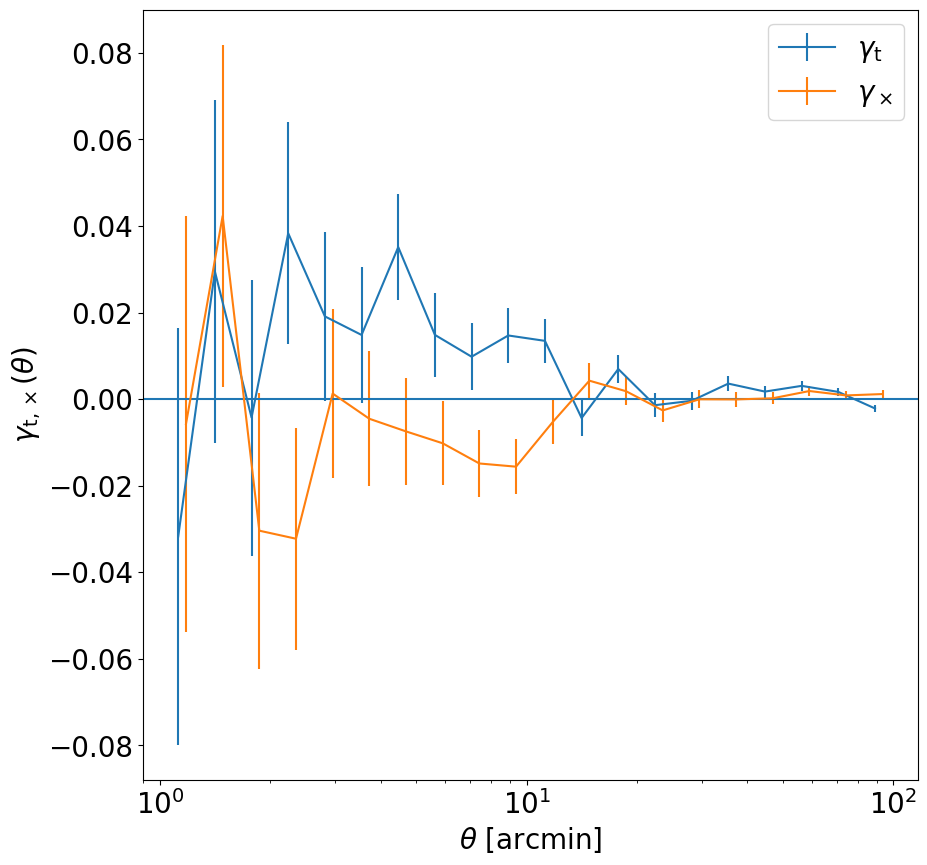

In [28]:
# Plot tangential and cross0component (E- and B-mode) with error bars
plt.errorbar(ng.rnom, ng.xi, yerr=np.sqrt(ng.varxi), label=r"$\gamma_{\rm t}$")
plt.errorbar(ng.rnom * 1.05, ng.xi_im, yerr=np.sqrt(ng.varxi), label=r"$\gamma_\times$")
plt.axhline(y=0)
plt.xscale("log")
plt.yscale("linear")
plt.xlabel(rf"$\theta$ [{sep_units}]")
plt.ylabel(r"$\gamma_{\rm t, \times}(\theta)$")
plt.legend()
_ = plt.savefig("gamma_clusters.png")

# 5. PSF systematic diagnostics (optional)

We can compute galaxy - PSF cross-correlation and leakage relations to quantify the influence of
PSF (residuals) on the measured shapes.

## 5.1. Galaxy - PSF cross-correlation function.

$\xi^{\rm sys}$ is defined as the normalised cross-correlation function of galaxy and PST ellipticities:
$$                                                                            
\xi^{\rm sys}_\pm(\theta) = \frac{\left( \xi_{\pm}^{\rm obs, PSF}(\theta) \right)^2}{\xi_{\pm}^{\rm PSF,  PSF}(\theta)}.
$$ 

In [29]:
# First, load the star and PSF catalogue unions_shapepipe_psf_2022_v1.0.2.fits.

d_star = fits.getdata("unions_shapepipe_psf_2022_v1.0.2.fits")

print(d_star.dtype.names)

# The ellipticity measurements were performed with the "HSM" (Hirata & Seljak 2003,
# https://ui.adsabs.harvard.edu/abs/2003MNRAS.343..459H/abstract and Mandelbaum et al. 2005,
# https://ui.adsabs.harvard.edu/abs/2005MNRAS.361.1287M/abstract) shape method,
# implemented in the library galsim.

# The catalogue contains the ellipticity for stars (E1_STAR_HSM, E2_STAR_HSM) and the PSF at the star
# positions (E1_PSF_HSM, E2_PSF_HSM).

('X', 'Y', 'RA', 'DEC', 'E1_PSF_HSM', 'E2_PSF_HSM', 'SIGMA_PSF_HSM', 'E1_STAR_HSM', 'E2_STAR_HSM', 'SIGMA_STAR_HSM', 'FLAG_PSF_HSM', 'FLAG_STAR_HSM', 'CCD_NB')


In [30]:
# Excercise 5.1 (optional):

# a) Compute xi_sys

# As before, use treecorr. This time, we need two shear catalogue objects, one for galaxies
# and one for the PSF. We can re-use the galaxy catalogue and config dictionary from before.

# The correlation instances are created via treecorr.GGCorrelation().
# The "xi_+" correlation function component is the class variable "xip".

# The correlation instances are created via treecorr.GGCorrelation().

In [31]:
# Create PSF catalogue
cat_psf = treecorr.Catalog(                                          
    ra=d_star["RA"],                                 
    dec=d_star["Dec"],  
    g1=d_star["E1_PSF_HSM"],
    g2=d_star["E2_PSF_HSM"],
    ra_units=coord_units,                                     
    dec_units=coord_units,                                    
)

In [32]:
# Create shear-shear correlation instance
gp = treecorr.GGCorrelation(TreeCorrConfig)

# Compute gal - PSF correlation
gp.process(cat_bg, cat_psf)

# Same for PSF - PSF correlation
pp = treecorr.GGCorrelation(TreeCorrConfig)
pp.process(cat_psf, cat_psf)

In [33]:
# Compute xi_sys

xi_sys = gp.xip ** 2 / pp.xip

In [34]:
# b) Compute the galaxy shear two-point correlation function and compare to xi_sys.

gg = treecorr.GGCorrelation(TreeCorrConfig)
gg.process(cat_bg, cat_bg)

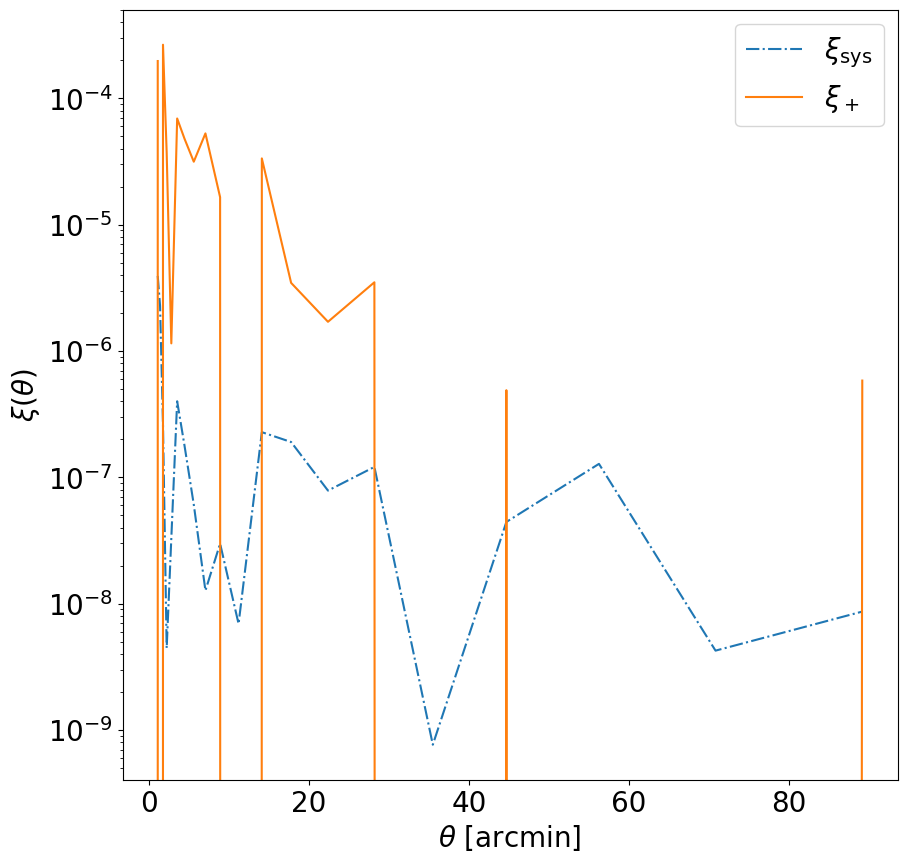

In [35]:
plt.plot(gp.rnom, xi_sys, "-.", label=r'$\xi_{\rm sys}$')
plt.plot(gg.rnom, gg.xip, "-", label=r'$\xi_+$')
plt.yscale("log")
plt.xlabel(r"$\theta$ [arcmin]")
plt.ylabel(r"$\xi(\theta)$")
plt.legend()
_ = plt.savefig("xi_sys_gg.png")

In [36]:
# As a bonus, calculate the error bars for xi_sys using error propagation of the individual correlation
# functions.

Gaussian error propagation starting with
$$                                                                            
\xi^{\rm sys}_\pm(\theta) = \frac{\left( \xi_{\pm}^{\rm obs, PSF}(\theta) \right)^2}{\xi_{\pm}^{\rm PSF,  PSF}(\theta)}.
$$
 gets us to

$$
\left( \Delta \xi^\textrm{sys}_\pm \right)^2
    = \left| \frac{2 \xi_{\pm}^{\rm obs, PSF}}{\xi_{\pm}^{\rm PSF,  PSF}} \right|^2
    \left( \Delta \xi^\textrm{obs,  PSF}_\pm \right)^2
    + \left| \frac{\left( \xi_{\pm}^{\rm obs, PSF} \right)^2}{\left( \xi_{\pm}^{\rm PSF,  PSF} \right)^2} \right|^2
    \left( \Delta \xi^\textrm{PSF,  PSF}_\pm \right)^2
$$
or, equivalently,

$$
\left( \frac{\Delta \xi^\textrm{sys}_\pm}{\xi^\textrm{sys}_\pm} \right)^2
    = \left( \frac{2 \Delta \xi_{\pm}^{\rm obs, PSF} }{\xi_{\pm}^{\rm obs, PSF}} \right)^2
    + \left( \frac{ \Delta \xi_{\pm}^{\rm PSF, PSF}}{\xi_{\pm}^{\rm PSF, PSF}} \right)^2 
$$
which leads to

$$
\Delta \xi^\textrm{sys}_\pm
    = \left| \xi^\textrm{sys}_\pm \right|
    \sqrt{
        \left( \frac{2 \Delta \xi_{\pm}^{\rm obs, PSF} }{\xi_{\pm}^{\rm obs, PSF}} \right)^2
        + \left( \frac{ \Delta \xi_{\pm}^{\rm PSF, PSF}}{\xi_{\pm}^{\rm PSF, PSF}} \right)^2
    }
$$

## 5.2 Object-wise PSF leakage

In [1]:
# Excercise 5.2 (optional): Compute object-wise PSF leakage

# First, for simplicity, we can fit one component at a time and neglect the spin consistency. So we
# perform four independent fits of
# eps^obs_i = alpha_ij eps^PSF_j + c_j
# for i, j = 1, 2.

from lmfit import minimize, Parameters

# Function to fit
def linear(params, x):
    return params["m"] * x + params["c"]

# Loss function = weighted difference between model and data
def loss(params, x, y, err):
    y_model = linear(params, x)
    residuals = (y_model - y) / err
    return residuals

# Set input data (y, x) and weights (here: all weights are 1)
y = ddm3["NGMIX_ELL_NOSHEAR"][:,0]
x = ddm3["NGMIX_ELL_PSFo_NOSHEAR"][:,0]
err = np.ones_like(y)

# Define parameter vector with (m, c) = (slope, intersept).
params = Parameters()
params.add("m")
params.add("c")

# Minimize loss function = fit for m, c
minimize(loss, params, args=(x, y, err))

NameError: name 'ddm3' is not defined

## 5.3 Scale-dependent PSF leakage

If we multiply the above equation $\mathbf\varepsilon^{\textrm{obs}}                                               = \mathbf{\alpha} \mathbf \varepsilon^{\textrm{PSF}}                               
      + \mathbf c$ with $\varepsilon^{\textrm{PSF}, \ast}$, take the expectation value and solve for $\alpha$, we find

$$
\alpha(\theta) = \frac{\xi_{+}^{\mathrm{obs, PSF}}(\theta)
- \Re\left( \langle e^{\mathrm{obs}} \rangle \langle e^{\mathrm{PSF}} \rangle^{*} \right)}{\xi_{+}^{\mathrm{PSF, PSF}}(\theta)},
$$

This is a similar equation to $\xi_{\rm sys}$, but it is directly derived from the (linear) PSF leakage model.

In [38]:
# Excercise 5.3 (optional):
# a) Compute and plot the scale-dependent PSF leakage function alpha(theta)

# Re-use the treecorr objects from above.

In [39]:
# Compute the <e^obs> <e^PSF> term
eg_ep = (
    np.mean(g_cal[0]) * np.mean(d_star["E1_PSF_HSM"])
    + np.mean(g_cal[1]) * np.mean(d_star["E2_PSF_HSM"])
)
print(eg_ep)

2.0371799376050705e-19


In [40]:
alpha = (gp.xip  - eg_ep) / pp.xip

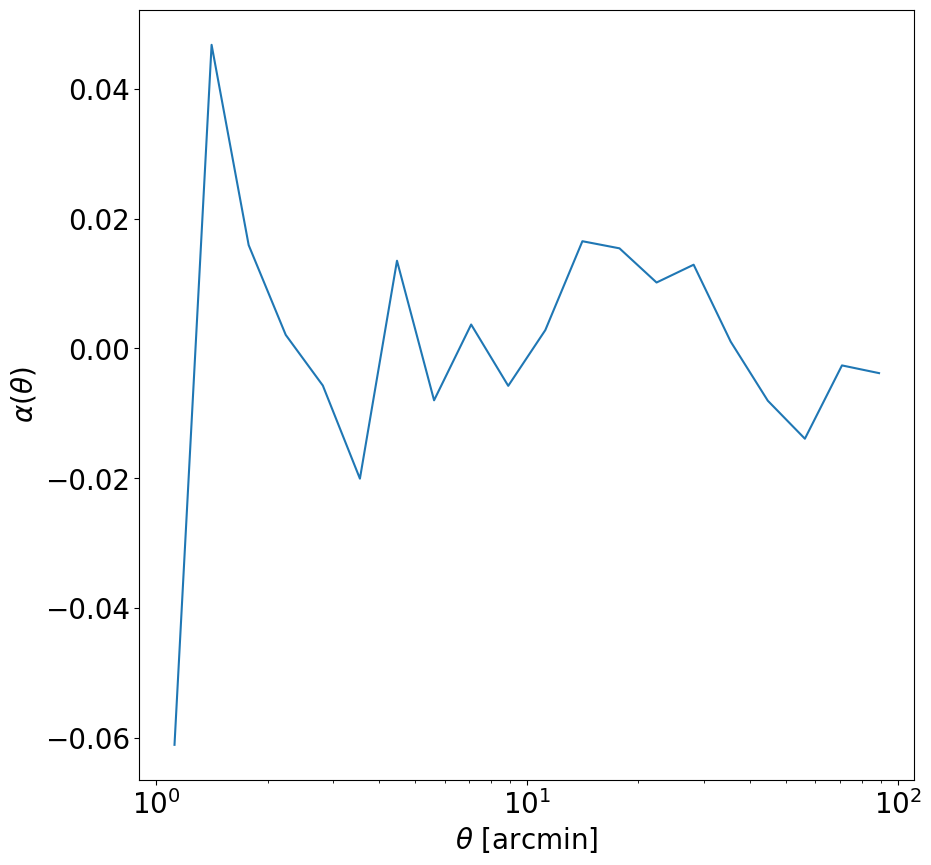

In [41]:
plt.plot(gp.rnom, alpha, '-')
plt.xscale("log")
plt.xlabel(r"$\theta$ [arcmin]")
plt.ylabel(r"$\alpha(\theta)$")
_ = plt.savefig("alpha.png")

In [ ]:
# b) Bonus: Compute and plot the errorbars.

$$
\alpha(\theta) = \frac{\xi_{+}^{\mathrm{obs, PSF}}(\theta)
- \Re\left( \langle e^{\mathrm{obs}} \rangle \langle e^{\mathrm{PSF}} \rangle^{*} \right)}{\xi_{+}^{\mathrm{PSF, PSF}}(\theta)},
$$

Ignoring the one-point correlators, we find

$$
    \left( \frac{\Delta \alpha}{\alpha} \right)^2
    = \left(
        \frac{
        \Delta \xi_+^{\mathrm{obs, PSF}}
      }{
        \xi_+^{\mathrm{obs, PSF}}
      }
      \right)^2
      + 
      \left(
        \frac{
        \Delta \xi_+^{\mathrm{PSF, PSF}}
      }{
        \xi_+^{\mathrm{PSF, PSF}}
      }
      \right)^2
$$
and therefore

$$
    \Delta \alpha
    = \left| \alpha \right|
    \sqrt{
    \left(
        \frac{
        \Delta \xi_+^{\mathrm{obs, PSF}}
      }{
        \xi_+^{\mathrm{obs, PSF}}
      }
      \right)^2
      + 
      \left(
        \frac{
        \Delta \xi_+^{\mathrm{PSF, PSF}}
      }{
        \xi_+^{\mathrm{PSF, PSF}}
      }
      \right)^2
    }
$$